In [1]:
import os
import numpy as np

import abtem
import ase
from ase.io import read

from ase.visualize import view
import matplotlib.pyplot as plt
%matplotlib ipympl

from ase import Atoms
from ase.build import bulk
from scipy.ndimage import rotate, zoom

In [2]:
# # get the propper dimmensions:
# path = './4nm_100111_loop_20nm_sys_structure.xyz'
# # path = './4nm_111111_loop_20nm_sys_structure.xyz'
# 
# atoms = read('4nm_100_loop_20nm.xyz', format='xyz')
# a = 200.05
# cell = [a, a, a]               
# atoms.set_cell(cell)   
# atoms.rotate(90, 'x', rotate_cell=True)
# 
# # Adjust unit cell
# tilt = 4 * np.sqrt(2)
# atoms.rotate(tilt, 'x', rotate_cell=False, center='COU')
# atoms.rotate(-tilt, 'y', rotate_cell=False, center='COU')
# atoms.wrap()
# print(f"Number of atoms: {len(atoms)}")
# 
# # Define the potential
# frozen_phonons = abtem.FrozenPhonons(atoms, 8, sigmas=0.1)
# potential = abtem.Potential(frozen_phonons, sampling=0.05) #0.03, then 0.1
# 
# # Define the probe
# probe = abtem.Probe(energy=200e3, semiangle_cutoff=4.5, Cs=10e4, defocus=-5)
# probe.grid.match(potential)
# 
# # Scattering matrix
# s_matrix = abtem.SMatrix(
#     potential=potential,
#     energy=200e3,
#     semiangle_cutoff=4.5, # was 4.5
#     interpolation=1 # was 4, maybe need to print # of gpts
# )
# s_matrix.build()
# print(s_matrix.gpts)
# 
# # Scan sampling
# sampling = abtem.transfer.nyquist_sampling(s_matrix.semiangle_cutoff, s_matrix.energy)
# sampling = sampling * 2  # should reduce computation by factor of 2
# scan = abtem.GridScan(
#     start=(0, 0),
#     end=(1,1),
#     fractional=True,
#     potential=potential,
#     sampling=sampling,
# )
# 
# print(f"Sampling: {sampling:.2f} Å^-1")
# 
# # Set up measurement
# detector = abtem.PixelatedDetector(max_angle = 'full')
# measurement= s_matrix.scan(
#     scan=scan,
#     detectors=detector,
#     ctf=probe.ctf,
# )

In [3]:
# import numpy as np
# 
# def get_relativistic_wavelength(energy_keV):
#     """Compute relativistic electron wavelength in Å"""
#     m0c2 = 511e3  # rest mass energy of electron in eV
#     E = energy_keV * 1e3  # convert keV to eV
#     lambda_rel = 12.3986 / np.sqrt(E * (1 + E / (2 * m0c2)))  # in Å
#     return lambda_rel
# 
# def compute_detector_pixel_size(semiangle_mrad, energy_keV, n_px):
#     theta = semiangle_mrad * 1e-3  # mrad to rad
#     wavelength = get_relativistic_wavelength(energy_keV)  # Å
#     q_max = 2 * np.pi / wavelength * theta  # Å⁻¹
#     dq = 2 * q_max / n_px  # Å⁻¹/pixel
#     return dq, q_max, wavelength
# 
# n_px = measurement.shape[-1]
# dq, q_max, lam = compute_detector_pixel_size(semiangle_mrad=4.5, energy_keV=200, n_px=n_px)
# 
# print(f"λ: {lam:.4f} Å")
# print(f"q_max: {q_max:.4f} Å⁻¹")
# print(f"Pixel size on detector: {dq:.4f} Å⁻¹/pixel")

In [4]:
# print(s_matrix.axes_metadata)
# real_space_psize = 0.05 # Ang/pixel

In [5]:
path = '/Users/austin/Desktop/Projects/BCC_Iron_Yao/completed_sims/'

files = os.listdir(path)
files = [f for f in files if '.npz' in f]
files.sort()
files

['Loop_100_-x_y.npz',
 'Loop_100_0x_y.npz',
 'Loop_100_x_-y.npz',
 'Loop_100_x_0y.npz',
 'Loop_100_x_y.npz',
 'Loop_111_-x_y.npz',
 'Loop_111_0x_y.npz',
 'Loop_111_x_-y.npz',
 'Loop_111_x_0y.npz',
 'Loop_111_x_y.npz']

In [6]:
file_name = files[-2]
file_name

'Loop_111_x_0y.npz'

In [7]:
file_name = files[-2]
# file_name = 'Loop_100_x_0y.npz'
recip_zoom_factor = 2

data = np.load(path + file_name)['arr_0']
data = zoom(data, (1, 1, recip_zoom_factor, recip_zoom_factor), order=3)
data.shape

(36, 36, 484, 484)

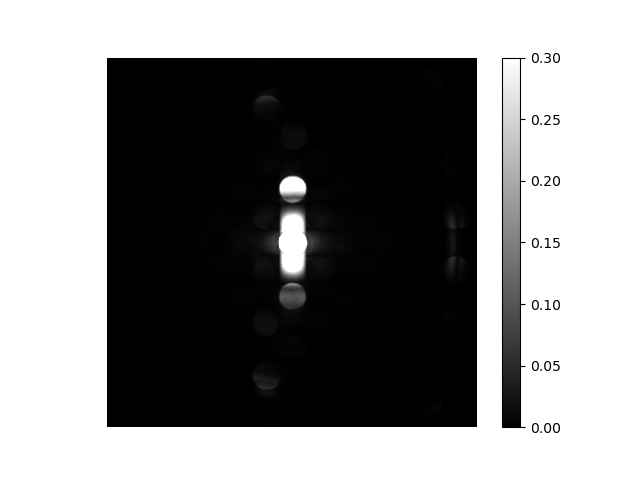

In [8]:
max_diff = np.max(data, axis=(0,1))
avg_im = np.mean(data, axis=(2,3))

max_diff -= max_diff.min()
max_diff /= max_diff.max()

plt.figure()
plt.imshow(max_diff, cmap='gray', vmax=0.3)
plt.axis('off')
plt.colorbar()

# plt.savefig(f'sim_ims/{file_name}_max_diff.png', dpi=300, bbox_inches='tight')

/var/folders/1h/36qxtl8567zdjv8nzdn4fzrr0000gn/T/ipykernel_76271/2311984906.py:2: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(avg_diff + 1e-6)


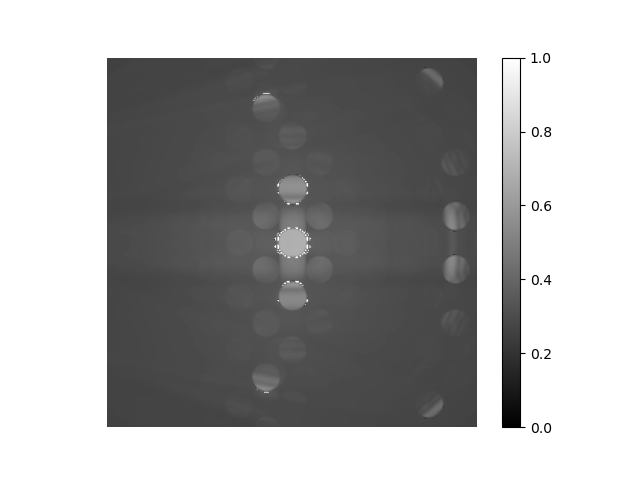

In [9]:
avg_diff = np.mean(data, axis=(0,1))
log_diff = np.log(avg_diff + 1e-6)
log_diff = np.nan_to_num(log_diff, neginf=0.0, posinf=0.0)
log_diff -= log_diff.min()
log_diff /= log_diff.max()

plt.figure()
plt.imshow(log_diff, cmap='gray')
plt.axis('off')
plt.colorbar()

In [10]:
file_name.split('_')

['Loop', '111', 'x', '0y.npz']

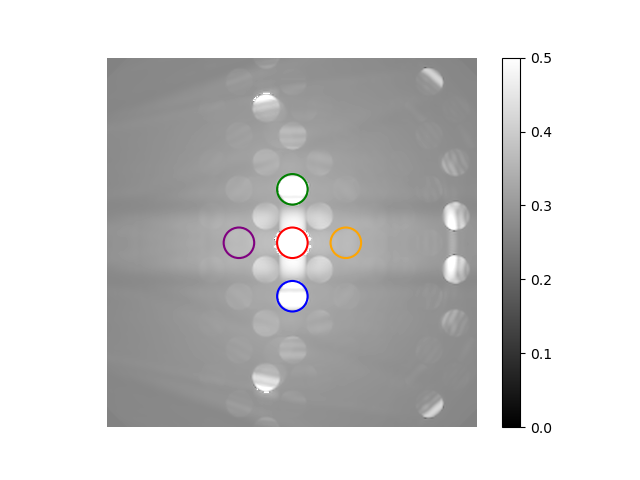

In [11]:
g = 8.75 * recip_zoom_factor * 2 # pixels
center = [data.shape[-1]//2, data.shape[-2]//2]

if '0' in file_name.split('_')[2]:
    g_vecs = np.array([[0,0],[0,2*g],[0,-2*g], [-2*g,0], [2*g,0]])
elif '0' in file_name.split('_')[3]:
    g_vecs = np.array([[0,0],[0,2*g],[0,-2*g], [-2*g,0], [2*g,0]])
else:
    g_vecs = np.array([[0,0],[2*g,2*g],[2*g,-2*g], [-2*g, 2*g], [-2*g,-2*g]])

g_vecs += center

detector_radius = 10 * recip_zoom_factor

colors = ['red', 'blue', 'green', 'purple', 'orange']

plt.figure()
plt.imshow(log_diff, cmap='gray', vmax=0.5)
plt.axis('off')
plt.colorbar()
# draw circles
for color, (cx, cy) in zip(colors, g_vecs):
    circle = plt.Circle((cx, cy), detector_radius, color=color, fill=False, lw=1.5)
    plt.gca().add_artist(circle)

# plt.savefig(f'sim_ims/{file_name}_virtual_detectors.png', dpi=300, bbox_inches='tight')

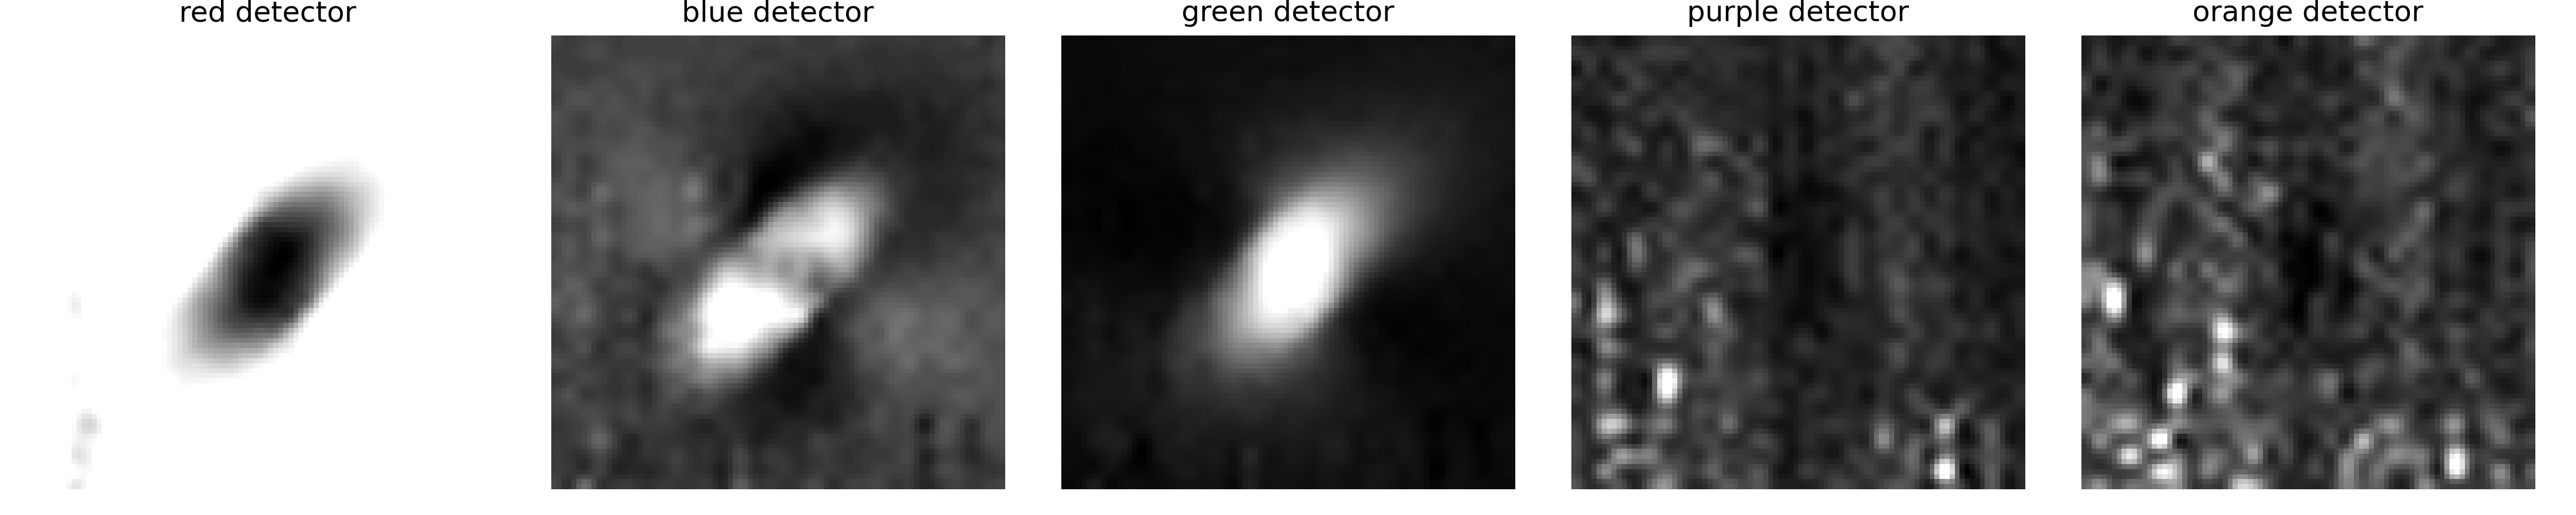

In [12]:

# Generate masks for each detector
diff_shape = data.shape[-2:]  # diffraction plane shape
Y, X = np.ogrid[:diff_shape[0], :diff_shape[1]]

masks = {}
for color, (cx, cy) in zip(colors, g_vecs):
    dist_sq = (X - cx)**2 + (Y - cy)**2
    masks[color] = dist_sq <= detector_radius**2  # Boolean mask

# Generate virtual images
virtual_images = {}
for color, mask in masks.items():
    # Apply mask over diffraction dimensions (last two dims of data)
    masked_data = data[..., mask]  
    virtual_image = masked_data.sum(axis=-1)  # Sum over masked diffraction pixels
    virtual_images[color] = virtual_image

# Edge cutoff
edge_cutoff = 3
for key in virtual_images:
    img = virtual_images[key]
    virtual_images[key] = img[edge_cutoff:-edge_cutoff, edge_cutoff:-edge_cutoff]

fig, axes = plt.subplots(1, len(virtual_images), figsize=(15, 3), dpi=300)
for ax, (color, img) in zip(axes, virtual_images.items()):
    img = zoom(img, zoom=3, order=2)
    img -= img.min()
    # img /= img.max()

    ax.imshow(img, cmap='gray', vmin=0, vmax=0.8*img.max())
    ax.set_title(f"{color} detector")
    ax.axis('off')
plt.tight_layout()
plt.show()

# plt.savefig(f'sim_ims/{file_name}_virtual_images.png', dpi=300, bbox_inches='tight')

In [14]:
fig, axes = plt.subplots(1, len(virtual_images), figsize=(15, 3), dpi=300)
images = []
for ax, (color, img) in zip(axes, virtual_images.items()):
    img = zoom(img, zoom=3, order=2)
    images.append(img)
    img -= img.min()
    
    ax.imshow(img, cmap='gray', vmin=0, vmax=0.8*img.max())
    ax.set_title(f"{color} detector")
    ax.axis('off')
plt.tight_layout()
# plt.savefig(f'sim_ims/{file_name}_virtual_images.png', dpi=300, bbox_inches='tight')
plt.close()

images = np.array(images)
np.savez(f'./{file_name}_virtual_images.npz', images)